In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from surprise import SVD, Dataset, Reader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

from CollabFilterOneVectorPerItem import CollabFilterOneVectorPerItem




In [90]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
data = Dataset.load_from_file('../data_movie_lens_100k/ratings_all_development_set.csv', reader=reader)
trainset = data.build_full_trainset()


user_info = pd.read_csv('../data_movie_lens_100k/user_info.csv', index_col='user_id')
user_info = user_info.drop('orig_user_id', axis='columns')


item_info = pd.read_csv('../data_movie_lens_100k/movie_info.csv', index_col='item_id')
item_info['title_id'] = item_info['title'].astype('category').cat.codes
item_info = item_info.drop(['orig_item_id', 'title'], axis='columns')




In [91]:
K_values = [2, 10, 50]
feature_sets = []
for K in K_values:
    # Apply SVD to get latent factors
    model = SVD(n_factors=K)
    model.fit(trainset)

    features = []
    labels = []

    for i, (uid, iid, rating) in enumerate(trainset.all_ratings()):
        raw_uid = int(trainset.to_raw_uid(uid))
        raw_iid = int(trainset.to_raw_iid(iid))
        user_features = user_info.loc[raw_uid]
        item_features = item_info.loc[raw_iid]
        user_embedding = model.pu[uid] 
        item_embedding = model.qi[iid]

        # Combining all features into a single feature vector
        combined_features = np.concatenate([user_embedding, item_embedding, user_features.values, item_features.values])
        features.append(combined_features)

        # Create labels: 1 if rating >= 4.0, otherwise 0
        label = 1 if rating > 4.0 else 0
        labels.append(label)

    feature_sets.append((features, labels))  # Append the feature set and corresponding labels for each K

In [284]:
model2 = SVD(n_factors=10)
model2.fit(trainset)
features1 = []
labels1 = []

for i, (uid, iid, rating) in enumerate(trainset.all_ratings()):
        raw_uid = int(trainset.to_raw_uid(uid))
        raw_iid = int(trainset.to_raw_iid(iid))
        user_features = user_info.loc[raw_uid]
        item_features = item_info.loc[raw_iid]
        user_embedding = model2.pu[uid] 
        item_embedding = model2.qi[iid]

# Combining all features into a single feature vector
        combined_features = np.concatenate([user_embedding, item_embedding, user_features.values, item_features.values])
        features1.append(combined_features)
        label = 1 if rating > 4.0 else 0
        labels1.append(label)

In [48]:
def train_evaluate_model(X_train, X_test, y_train, y_test, classifier, param_grid, scaler=None):
    if scaler:
        pipe = make_pipeline(scaler, classifier)
    else:
        pipe = make_pipeline(classifier)

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Predict probabilities and compute ROC AUC
    y_scores = best_model.predict_proba(X_test)[:, 1]  # probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return grid_search.best_params_, roc_auc

In [302]:
param_grid_gradient_boost = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__max_depth': [3, 5],
    'gradientboostingclassifier__learning_rate': [0.01, 0.1],
    'gradientboostingclassifier__min_samples_leaf': [1, 3],  # Minimum number of samples required to be at a leaf node
}


param_grid_svm = {
    'svc__C': [1],  # Regularization parameter. The strength of the regularization is inversely proportional to C.
    'svc__kernel': ['rbf'],  # Specifies the kernel type to be used in the algorithm.
    'svc__gamma': ['auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid', 
}

param_grid_MLP = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 100)],  # Sizes of the hidden layers.
    'activation': ['tanh', 'relu'],  # Activation function for the hidden layer.
    'solver': ['sgd', 'adam'],  # The solver for weight optimization.
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter.
    'learning_rate_init': [0.001, 0.01],  # The initial learning rate used.
    'max_iter': [200, 300, 500],  # Maximum number of iterations.
    'shuffle': [True],  # Whether to shuffle samples in each iteration.
    'beta_1': [0.9, 0.95],  # Exponential decay rate for estimates of first moment vector in adam.
    'beta_2': [0.999, 0.995],  # Exponential decay rate for estimates of second moment vector in adam.
}



In [303]:
# features, labels = feature_sets[2]

print(f"Results for K = {K_values[2]}:")
print("GradientBoostingClassifier:")
gb_model = MLPClassifier(early_stopping=True, activation='relu')
n_splits = 10
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
grid_search = GridSearchCV(gb_model, param_grid_MLP, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(features1, labels1)

# best_params_gbm, roc_auc_gbm = train_and_evaluate_model(x_train, x_test, y_train, y_test, gb_model, param_grid_MLP, StandardScaler())
print("Best Parameters:", grid_search.best_params_, grid_search.best_score_)
# print("ROC AUC:", roc_auc_gbm)

Results for K = 50:
GradientBoostingClassifier:
Fitting 10 folds for each of 864 candidates, totalling 8640 fits
[CV] END activation=tanh, alpha=0.0001, beta_1=0.9, beta_2=0.999, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=200, shuffle=True, solver=sgd; total time=   3.1s
[CV] END activation=tanh, alpha=0.0001, beta_1=0.9, beta_2=0.999, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=200, shuffle=True, solver=sgd; total time=   3.5s
[CV] END activation=tanh, alpha=0.0001, beta_1=0.9, beta_2=0.999, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=200, shuffle=True, solver=sgd; total time=   3.7s
[CV] END activation=tanh, alpha=0.0001, beta_1=0.9, beta_2=0.999, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=200, shuffle=True, solver=sgd; total time=   3.8s
[CV] END activation=tanh, alpha=0.0001, beta_1=0.9, beta_2=0.999, hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=200, shuffle=True, solver=sgd; total time=   3.

In [296]:
best_MLP = MLPClassifier(**grid_search.best_params_)

In [237]:
type(labels)

list

In [297]:
best_MLP.fit(features1, labels1)

MLPClassifier(hidden_layer_sizes=(32,))

In [288]:
ratings = pd.read_csv('../data_movie_lens_100k/ratings_masked_leaderboard_set.csv')
ratings['rating'].fillna(-1, inplace=True)
ratings.to_csv('../data_movie_lens_100k/ratings_cleaned.csv', index=False)
ratings




,user_id,item_id,rating
0,503,204,-1.0
1,795,185,-1.0
2,42,403,-1.0
3,327,740,-1.0
4,285,98,-1.0
...,...,...,...
9995,463,292,-1.0
9996,372,485,-1.0
9997,763,190,-1.0
9998,499,163,-1.0


In [289]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5), skip_lines=1)
data = Dataset.load_from_file('../data_movie_lens_100k/ratings_cleaned.csv', reader=reader)
testset = data.build_full_trainset()

user_info = pd.read_csv('../data_movie_lens_100k/user_info.csv', index_col='user_id')
user_info = user_info.drop('orig_user_id', axis='columns')


item_info = pd.read_csv('../data_movie_lens_100k/movie_info.csv', index_col='item_id')
item_info['title_id'] = item_info['title'].astype('category').cat.codes
item_info = item_info.drop(['orig_item_id', 'title'], axis='columns')


In [298]:
model = SVD(n_factors=50)
model.fit(testset)
test_features = []

for i, (uid, iid, rating) in enumerate(testset.all_ratings()):
        raw_uid = int(testset.to_raw_uid(uid))
        raw_iid = int(testset.to_raw_iid(iid))
        user_features = user_info.loc[raw_uid]
        item_features = item_info.loc[raw_iid]
        user_embedding = model.pu[uid] 
        item_embedding = model.qi[iid]

# Combining all features into a single feature vector
        combined_features = np.concatenate([user_embedding, item_embedding, user_features.values, item_features.values])
        test_features.append(combined_features)

In [299]:
array = best_MLP.predict(test_features)

ValueError: X has 24 features, but MLPClassifier is expecting 104 features as input.

In [ ]:
array

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
with open('predicted_ratings_leaderboard.txt', 'w') as file:
    for item in array:
        file.write(f"{item}\n") 

Results for K = 2:
GradientBoostingClassifier:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time= 8.1min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time= 8.1min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time= 8.1min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time= 8.1min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time= 8.1min


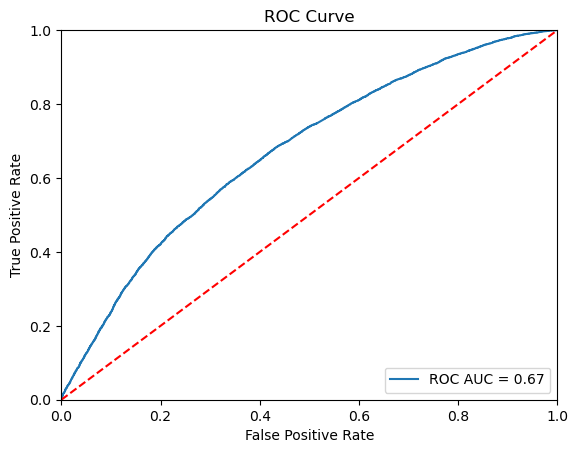

Best Parameters: {'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
ROC AUC: 0.6718354445995682
Results for K = 10:
GradientBoostingClassifier:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=16.6min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=16.6min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=16.6min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=16.6min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=16.7min


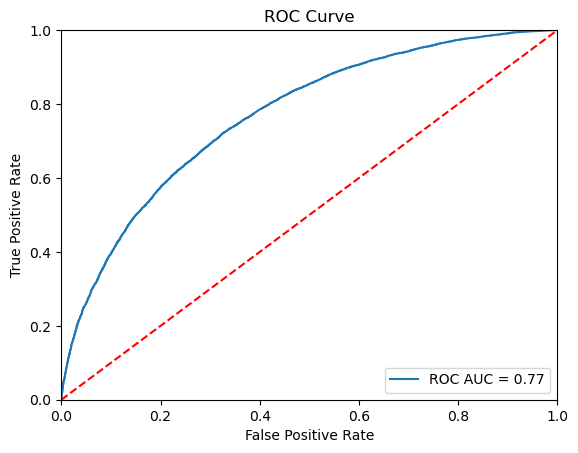

Best Parameters: {'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
ROC AUC: 0.7685184776586773
Results for K = 50:
GradientBoostingClassifier:
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=58.6min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=58.7min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=58.7min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=58.9min
[CV] END .........svc__C=1, svc__gamma=auto, svc__kernel=rbf; total time=59.2min


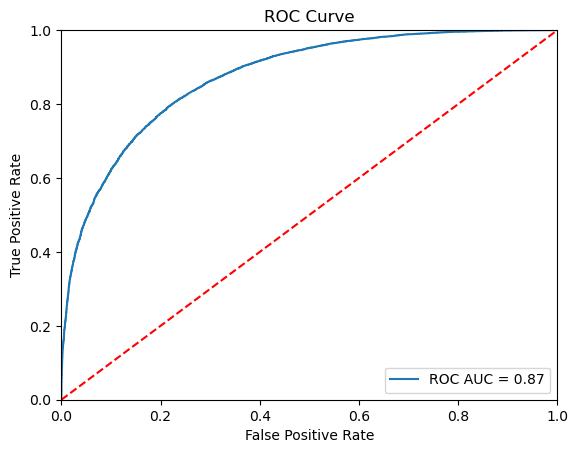

Best Parameters: {'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
ROC AUC: 0.8745206277941853


In [57]:
for index, (features, labels) in enumerate(feature_sets):
        x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
        print(f"Results for K = {K_values[index]}:")
        print("GradientBoostingClassifier:")
        svm_model = SVC(probability=True)
        best_params_svm, roc_auc_svm = train_and_evaluate_model(x_train, x_test, y_train, y_test, svm_model, param_grid_svm, StandardScaler())
        print("Best Parameters:", best_params_svm)
        print("ROC AUC:", roc_auc_svm)